In [3]:
from pathlib import Path
import logging
import math

import pytorch_lightning as pl
import matplotlib.pyplot as plt
from torch.nn.functional import softmax
import torch
import numpy as np
from torchvision import transforms
from pytorch_lightning import seed_everything

from solarnet.utils.plots import plot_confusion_matrix, plot_image_grid
from solarnet.utils.target import flux_to_class_builder
from solarnet.utils.log import init_log, set_log_level
from solarnet.models import ImageClassification
from solarnet.data import SDOBenchmarkDataModule, SDODatasetDataModule
from solarnet.utils.yaml import load_yaml
from solarnet.data import datamodule_from_config
from solarnet.data.transforms import sdo_dataset_normalize, SDOSimCLRDataTransform

init_log()
set_log_level(logging.INFO)

/home/jonathan.donzallaz/anaconda3/envs/solarnet-conda-env/lib/python3.8/site-packages/pytorch_lightning/core/decorators.py:64: LightningDeprecationWarning: The `@auto_move_data` decorator is deprecated in v1.3 and will be removed in v1.5. Please use `trainer.predict` instead for inference. The decorator was applied to `forward`
  rank_zero_deprecation(


In [4]:
# Parameters
parameters = {
    "data": {
        "validation_size": 0.1,
        "channel": "171",
        "size": 256,
        "time_steps": 3,#[0,1,2,3],
        "targets": {
            "classes": [{"Quiet": "< 1e-4"},{">=C": ">= 1e-4"}],
        },
    },
    "trainer": {
        "epochs": 5,
        "batch_size": 32,
    },
    "seed": 42,
    "system": {
        "workers": 20,
        "gpus": 0,
    }
}

In [20]:
# Load data
def load_data(parameters):
    datamodule = SDOBenchmarkDataModule(
        Path("../") / "data" / "sdo-benchmark",
        batch_size=parameters["trainer"]["batch_size"],
        validation_size=parameters["data"]["validation_size"],
        channel=parameters["data"]["channel"],
        resize=parameters["data"]["size"],
        seed=parameters["seed"],
        num_workers=parameters["system"]["workers"],
        target_transform=flux_to_class_builder(parameters["data"]["targets"]["classes"]),
        time_steps=parameters["data"]["time_steps"],
    )
    datamodule.setup()

    sample = next(iter(datamodule.test_dataloader()))  # select the first sample
    sample_data = sample[0]
    sample_labels = sample[1]
    sample_data = sample_data.squeeze()  # torch.Size([32, 1, 256, 256])   ->   torch.Size([32, 256, 256])

    return sample_data, sample_labels

torch.Size([32, 256, 256])
tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


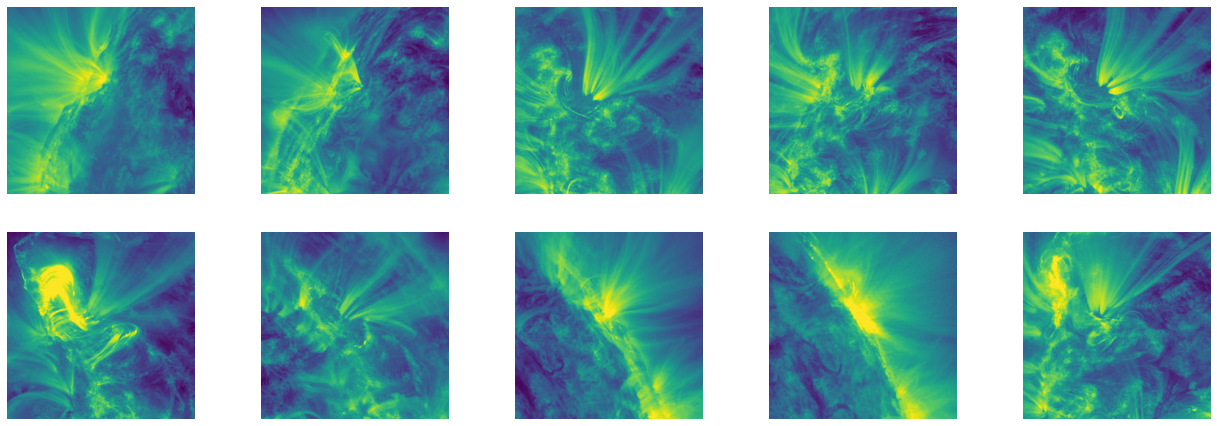

In [21]:
# TEMPORARY
sample_data, sample_labels = load_data(parameters)
print(sample_data.shape)
print(sample_labels)
plot_image_grid(sample_data)

torch.Size([32, 4, 256, 256])
tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


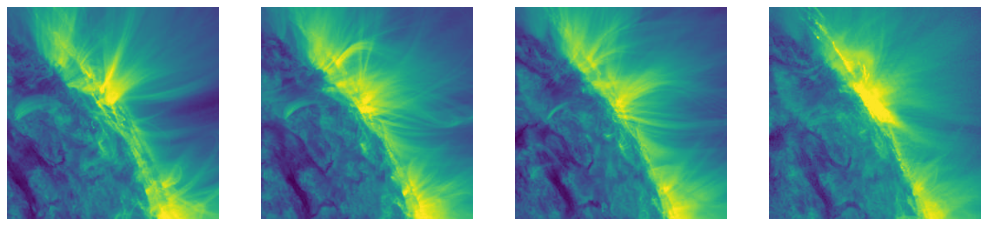

In [22]:
parameters["data"]["time_steps"] = [0,1,2,3]
sample_data, sample_labels = load_data(parameters)
print(sample_data.shape)
print(sample_labels)
imgs = [i for i in sample_data[8]]
plot_image_grid(imgs, labels=["10 min", "1.5 hour", "5 hours", "12 hours"])

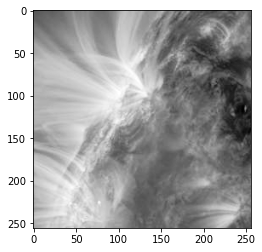

In [24]:
plt.imshow(sample_data[1][0], cmap="Greys_r");

In [25]:
sample_data[1][0]

tensor([[-0.1059, -0.1059, -0.1059,  ...,  0.0039,  0.0118,  0.0118],
        [-0.0980, -0.0980, -0.0980,  ...,  0.0039, -0.0039, -0.0118],
        [-0.0824, -0.0824, -0.0824,  ..., -0.0039, -0.0275, -0.0275],
        ...,
        [ 0.3490,  0.3490,  0.3490,  ..., -0.0667, -0.0902, -0.1137],
        [ 0.3255,  0.3333,  0.3333,  ..., -0.0902, -0.0902, -0.0824],
        [ 0.3098,  0.3176,  0.3255,  ..., -0.1059, -0.0824, -0.0510]])

# ... Verified until here

---

In [24]:
dm = SDOBenchmarkDataModule(Path("../data/sdo-benchmark"))
dm = SDODatasetDataModule(Path("../data/sdo-dataset-ssl-bz-1h-month"))
dm.setup()

In [25]:
dl = dm.train_dataloader()
batch = next(iter(dl))

In [26]:
# batch[0].shape
t = torch.tensor_split(batch[0], dm.batch_size)
t = [i[0,0] for i in t]
print(len(t), t[0].shape)

32 torch.Size([512, 512])


In [27]:
w = 22
m = 10
c = 3
h = w * (m // c) / c * 1.33 # 6
# print(h)
# height = 12
# height = max(height, int(len(images) / columns) * height)
# plot_image_grid(t, max_images=m, columns=c, width=w, height=h)
import math
math.ceil(8 / 5)

2

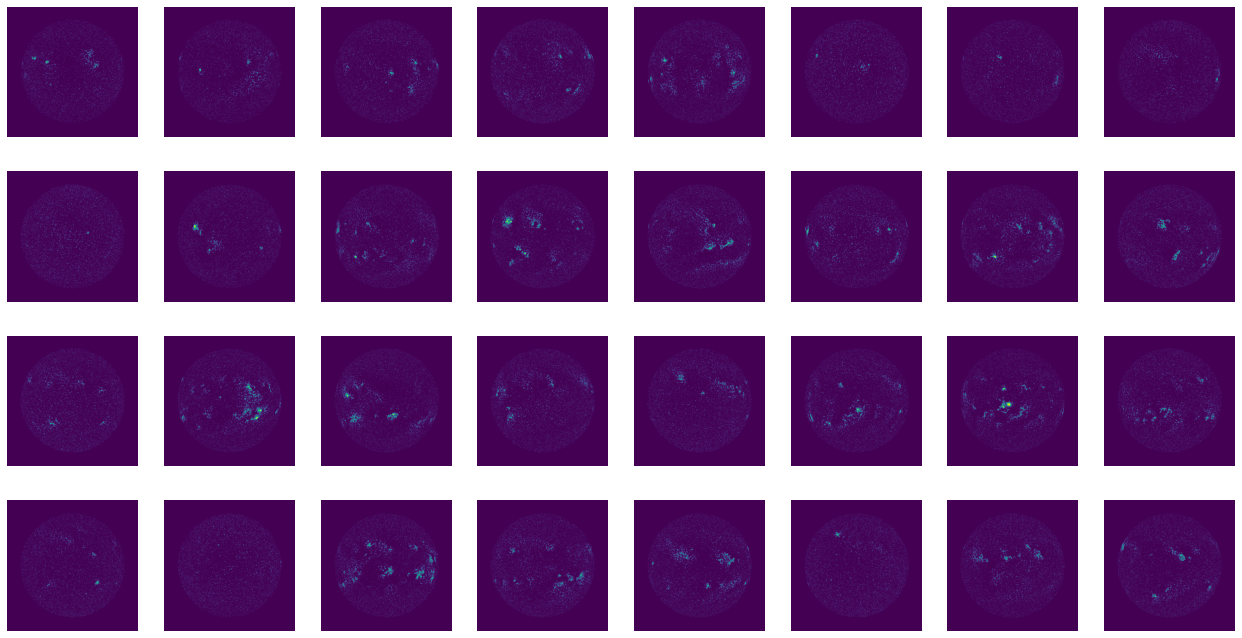

In [28]:
plot_image_grid(t, max_images=32, columns=8)

In [29]:
ds = dl.dataset
ds

In [30]:
[list(c.keys())[0] for c in [{"Quiet": "< 1e-6"},{">=C": ">= 1e-6"}]]

['Quiet', '>=C']

In [31]:
str(dm.size())

'(1, 512, 512)'

In [32]:
path = Path("../models/baseline_binary_sdodataset")
p = load_yaml(path / "config.yaml")
pl.seed_everything(p["seed"])
datamodule = datamodule_from_config(p)
model = ImageClassification.load_from_checkpoint(str(path / "model.ckpt"))
trainer = pl.Trainer(
    gpus=0,
    logger=None,
)
t = transforms.Compose(
    [
        transforms.CenterCrop((512 // 2, 512 - 512 // 8)),
        sdo_dataset_normalize(p["data"]["channel"], p["data"]["size"]),
    ]
)
datamodule = SDODatasetDataModule(
    Path('../data/sdo-dataset-cls-211-24h-mix'),
    channel=p["data"]["channel"],
    target_transform=flux_to_class_builder(p["data"]["targets"]["classes"]),
    batch_size=p["trainer"]["batch_size"],
    resize=p["data"]["size"],
    num_workers=p["system"]["workers"],
    transform=t,
)
datamodule.setup("test")

Global seed set to 42
GPU available: True, used: False
TPU available: False, using: 0 TPU cores


In [37]:
p = torch.cat(p)
p = torch.argmax(p, dim=1).tolist()

In [38]:
len([i for i in p if i == 0])

0

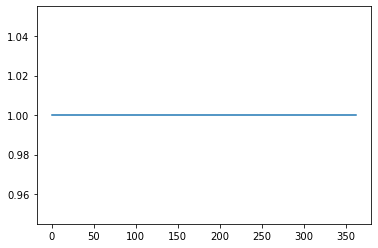

In [39]:
plt.plot(p);

In [41]:
t = torch.rand((32,1,256,256))
print(t.shape)
backbone(t).shape

torch.Size([32, 1, 256, 256])


NameError: name 'backbone' is not defined

In [42]:
seed_everything(42, workers=True)
base_resize = 512
transform = SDOSimCLRDataTransform(
    128,
    do_online_transform=True,
    transform_before=transforms.CenterCrop((base_resize // 2, base_resize - base_resize // 8)),
    transform_after=sdo_dataset_normalize(171),
)

dm = SDODatasetDataModule(Path("../data/sdo-dataset-ssl-171-1h-1"), channel=171, transform=transform)
dm.setup()
dl = dm.train_dataloader()
batch = next(iter(dl))

Global seed set to 42


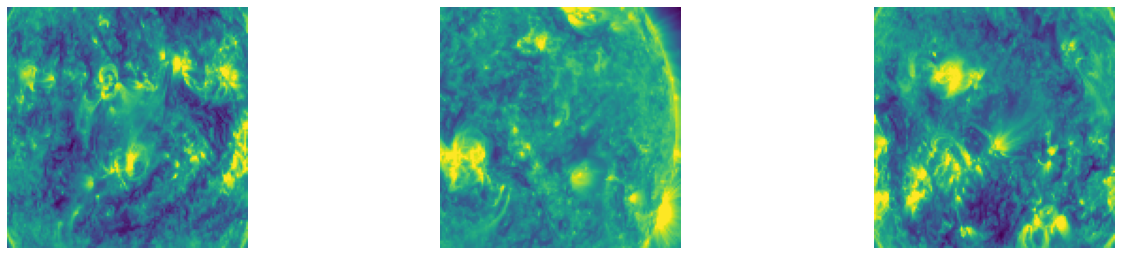

In [43]:
plot_image_grid([i[0] for i in batch[0][0]], max_images=3, columns=3)#, width=22, height=12)

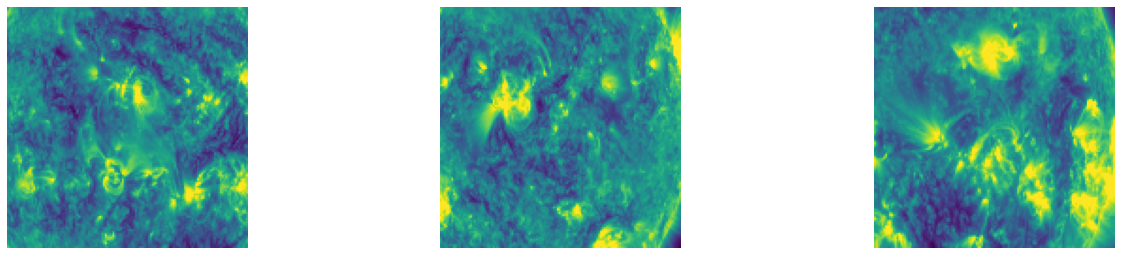

In [44]:
plot_image_grid([i[0] for i in batch[0][1]], max_images=3, columns=3)


In [45]:
plot_image_grid([i[0] for i in batch[0][3]], max_images=3, columns=3)

IndexError: list index out of range

Global seed set to 42


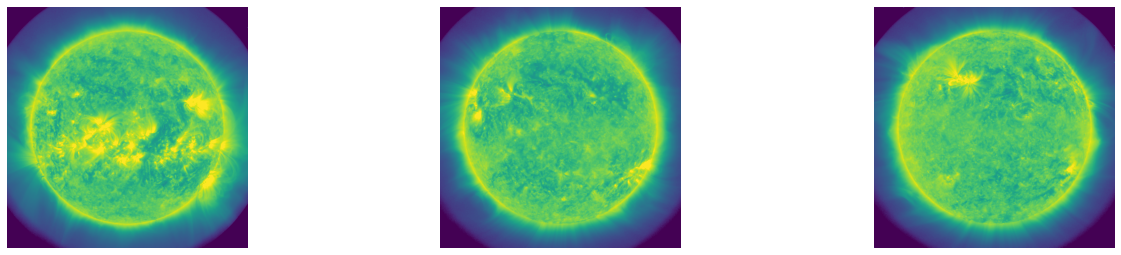

In [46]:
seed_everything(42, workers=True)
dm2 = SDODatasetDataModule(Path("../data/sdo-dataset-ssl-171-1h-1"), channel=171, transform=None)
dm2.setup()
dl2 = dm2.train_dataloader()
batch2 = next(iter(dl2))
plot_image_grid([i[0] for i in batch2[0]], max_images=3, columns=3)

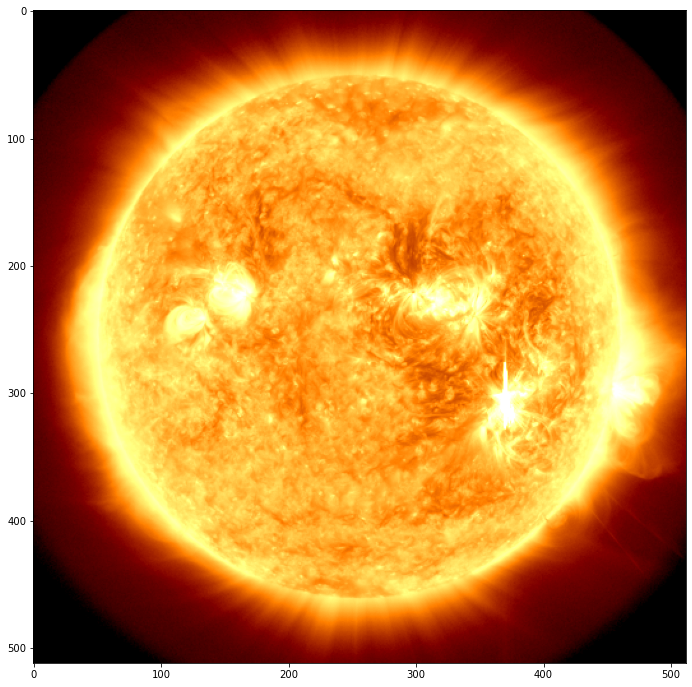

In [49]:

# img1 = "c:/code/master/AIA20110101_1200_0171.npz"
img1 = "/data1/data/sdo-dataset/171/2017/09/06/AIA20170906_1200_0171.npz"
# img2 = "c:/code/master/HMI20110101_1200_bz.npz"

img = np.load(img1)["x"].astype(np.float64)
img = torch.from_numpy(img).unsqueeze(0)
img = sdo_dataset_normalize(171)(img)
img = img[0].numpy()
plt.figure(figsize=(12, 12))
# plt.imshow(img);
# plt.imshow(img, cmap="gray");
plt.imshow(img, cmap="afmhot");
# plt.show();
# plt.imsave("c:/code/master/AIA20110101_1200_0171_clip.png",img, cmap="afmhot")
# plt.imsave("c:/code/master/AIA20110101_1200_bz_nopp.png",img, cmap="gray")
# images = crop_center(images, 430, 200)
# plt.imshow(images);




In [48]:
import math
from typing import Callable, Optional, Union

import torch
from torchvision.transforms import transforms
import torchvision.transforms.functional as transforms_functional

# Same preprocess as github.com/i4Ds/SDOBenchmark
CHANNEL_PREPROCESS = {
    "171": {"min": 5, "max": 8500, "scaling": "log10"},
    "193": {"min": 20, "max": 5500, "scaling": "log10"},
    "211": {"min": 7, "max": 3500, "scaling": "log10"},
    "magnetogram": {"min": -250, "max": 250, "scaling": None},
    "bx": {"min": -250, "max": 250, "scaling": None},
    "by": {"min": -250, "max": 250, "scaling": None},
    "bz": {"min": -250, "max": 250, "scaling": None},
}


def sdo_dataset_normalize(channel: Union[str, int], resize: Optional[int] = None):
    preprocess_config = CHANNEL_PREPROCESS[str(channel).lower()]

    lambda_transform = lambda x: torch.clamp(
        transforms_functional.vflip(x),
        min=preprocess_config["min"],
        max=preprocess_config["max"],
    )

    mean = preprocess_config["min"]
    std = preprocess_config["max"] - preprocess_config["min"]

    if preprocess_config["scaling"] == "log10":
        base_lambda = lambda_transform
        lambda_transform = lambda x: torch.log10(base_lambda(x))
        mean = math.log10(preprocess_config["min"])
        std = math.log10(preprocess_config["max"]) - math.log10(preprocess_config["min"])

    transform = [
        transforms.Lambda(lambda_transform),
        transforms.Normalize(mean=[mean], std=[std]),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ]

    if resize is not None:
        transform.insert(0, transforms.Resize(resize))

    return transforms.Compose(transform)